In [1]:
import torch
import os
import h5py
import pandas as pd
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from utils.T1Dataset import T1Dataset_regression_mr_path_test,T1Dataset_regression_test
from torch.utils.data import Dataset, DataLoader
from lifelines.utils import concordance_index
from models.SENet import Model_path_mr,Model
from utils.img_processing import convert_path,name_pinyin
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [2]:
base_dir = ['G:/glioma/final_data/huashan_MR/npy_file/TCGA_npy','G:/glioma/final_data/huashan_MR/npy_file/glioma_huashan_npy']
base_dir_path = ['G:/glioma/final_data/huashan_MR/pathology/TCGA','G:/glioma/final_data/huashan_MR/pathology/huashan']
df_dir = ['G:/glioma/final_data/glioma_survive/TCGA.csv','G:/glioma/final_data/glioma_survive/huashan.csv']
pth_dir = ['G:/glioma/final_data/glioma_survive/only_mr/gbm_survive_cnn_min_loss_only_mr.pth',
           'G:/glioma/final_data/glioma_survive/only_mr/survive_cnn_min_loss_only_mr_huashan.pth']
csv_dir = [['G:/glioma/final_data/glioma_survive/only_mr/test_TCGA.csv','G:/glioma/final_data/glioma_survive/only_mr/train_TCGA.csv',
           'G:/glioma/final_data/glioma_survive/only_mr/ex_test_huashan.csv','G:/glioma/final_data/glioma_survive/only_mr/ex_train_huashan.csv'],
           ['G:/glioma/final_data/glioma_survive/only_mr/test_huashan.csv','G:/glioma/final_data/glioma_survive/only_mr/train_huashan.csv',
            'G:/glioma/final_data/glioma_survive/only_mr/ex_test_TCGA.csv','G:/glioma/final_data/glioma_survive/only_mr/ex_train_TCGA.csv']]
i = 0
ex_i = 1 # 外部验证
device = "cuda" if torch.cuda.is_available() else "cpu"
df = pd.read_csv(df_dir[i])
df_train, df_test, y_train, y_test = train_test_split(df,df['patient'],test_size=0.2,random_state=2022)
train_ds = T1Dataset_regression_test(df_train,base_dir[i])
test_ds = T1Dataset_regression_test(df_test,base_dir[i])
train_dl = DataLoader(
                        train_ds,
                        shuffle=True,
                        batch_size = 8,
    )
test_dl = DataLoader(
                        test_ds,
                        batch_size = 8,
    )


In [3]:
checkpoint = torch.load(pth_dir[i])
model = Model(num_classes=1)
model.load_state_dict(checkpoint['state_dict'])
model.to(device)
model.eval()
with torch.no_grad():
    for itr,(images,day,event,name) in enumerate(test_dl):
        name = np.array(name).tolist()
        images = images.to(device)
        risk_score = model(images.float()).squeeze()
        if itr == 0:
            deep_score_test = risk_score.cpu()
            patient_test = name
        else:
            deep_score_test = torch.cat((deep_score_test, risk_score.cpu()),0)
            patient_test = patient_test + name
state_test = {
    'patient': patient_test,
    'score': deep_score_test
}
df_test_ = pd.DataFrame(state_test)
df_test_ = pd.merge(df_test_,df_test,how='inner')
df_test_.to_csv(csv_dir[i][0],index = False)

with torch.no_grad():
    for itr,(images,day,event,name) in enumerate(train_dl):
        name = np.array(name).tolist()
        images = images.to(device)
        risk_score = model(images.float()).squeeze()
        if itr == 0:
            deep_score_train = risk_score.cpu()
            patient_train = name
        else:
            deep_score_train = torch.cat((deep_score_train, risk_score.cpu()),0)
            patient_train = patient_train + name
state_train = {
    'patient': patient_train,
    'score': deep_score_train
}
df_train_ = pd.DataFrame(state_train)
df_train_ = pd.merge(df_train_,df_train,how='inner')
df_train_.to_csv(csv_dir[i][1],index = False)

In [4]:
df_ex = pd.read_csv(df_dir[ex_i])
df_train_ex, df_test_ex, y_train, y_test = train_test_split(df_ex,df_ex['patient'],test_size=0.69,random_state=10) 
# 10
train_ds_ex = T1Dataset_regression_test(df_train_ex,base_dir[ex_i])
train_dl_ex = DataLoader(
                        train_ds_ex,
                        batch_size = 8,
    )
with torch.no_grad():
    for itr,(images,day,event,name) in enumerate(train_dl_ex):
        name = np.array(name).tolist()
        images = images.to(device)
        risk_score = model(images.float()).squeeze()
        if itr == 0:
            deep_score_test_ex = risk_score.cpu()
            patient_test_ex = name
        else:
            deep_score_test_ex = torch.cat((deep_score_test_ex, risk_score.cpu()),0)
            patient_test_ex = patient_test_ex + name
state_test_ex = {
    'patient': patient_test_ex,
    'score': deep_score_test_ex
}
df_test_ex_ = pd.DataFrame(state_test_ex)
df_test_ex_ = pd.merge(df_test_ex_,df_train_ex,how='inner')
df_test_ex_.to_csv(csv_dir[i][3],index = False)


In [38]:
csv_dir[i][0]

'G:/glioma/final_data/glioma_survive/only_mr/test_TCGA.csv'

In [5]:
from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
y_train_ = Surv.from_dataframe(
    event='status_dead', 
    time='survival_month', 
    data=df_train_)
y_test_ = Surv.from_dataframe(
    event='status_dead', 
    time='survival_month', 
    data=df_test_)
y_ex_test_ = Surv.from_dataframe(
    event='status_dead', 
    time='survival_month', 
    data=df_test_ex_)
hazard_label = ['score','WHO','Age','Gender','IDH']
train_feature = df_train_[hazard_label].values
test_feature = df_test_[hazard_label].values
ex_test_feature = df_test_ex_[hazard_label].values
# cox 模型
cph = CoxPHSurvivalAnalysis()
cph.fit(train_feature, y_train_)
cph_score = cph.score(test_feature,y_test_)
print("cph C-index: ", cph_score)
cph_score_ex = cph.score(ex_test_feature,y_ex_test_)
print("ex cph C-index: ", cph_score_ex)

cph C-index:  0.9016393442622951
ex cph C-index:  0.7692307692307693


Text(0.5, 1.0, 'Time ROC in Feature Extractor Base only MR')

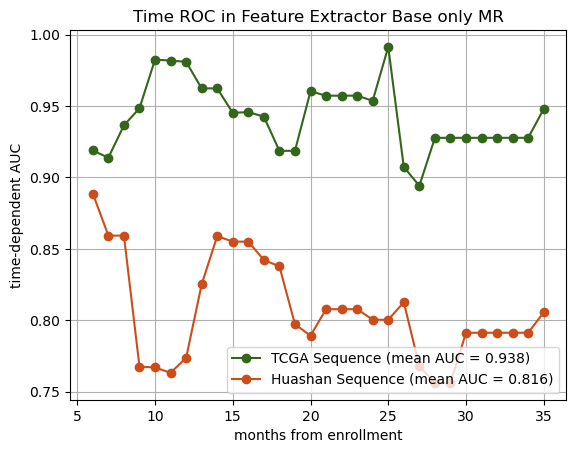

: 

In [8]:
va_times = np.arange(6, 36, 1)
cph_risk_scores = cph.predict(test_feature)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_train_, y_test_, cph_risk_scores, va_times)

cph_risk_scores_ex = cph.predict(ex_test_feature)
cph_auc_ex, cph_mean_auc_ex = cumulative_dynamic_auc(y_train_, y_ex_test_, cph_risk_scores_ex, va_times)




plt.plot(va_times, cph_auc,color=(0.2, 0.4, 0.1) ,marker="o",label=f"TCGA Sequence (mean AUC = {cph_mean_auc:.3f})")
plt.plot(va_times, cph_auc_ex,color=(0.8, 0.3, 0.1) ,marker="o",label=f"Huashan Sequence (mean AUC = {cph_mean_auc_ex:.3f})")
# plt.axhline(cph_mean_auc, linestyle="--",color=(0.8, 0.3, 0.1))

plt.xlabel("months from enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower right")
plt.grid(True)
plt.title('Time ROC in Feature Extractor Base only MR')

In [29]:
def normalize(X, X_min, X_max):    
    """    对矩阵X进行0-1标准化    """    
    X_norm = (X - X_min) / (X_max - X_min)    
    return X_norm
def restore_data(X,X_min,X_max):
    X_origin = X * (X_max - X_min) + X_min
    return X_origin
# 训练集归一化
X_processing =df_train_['score'].values.reshape(-1, 1)
max_value, min_value = X_processing.max(),X_processing.min()
scaler = MinMaxScaler()
scaler.fit(X_processing)
X_processing1 = scaler.transform(X_processing)
df_train_['score'] = X_processing1

# 测试集归一化
X_processing =df_test_['score'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaler.fit(X_processing)
X_processing1 = scaler.transform(X_processing)
df_test_['score'] = X_processing1

# 外部测试集归一化
X_processing =df_test_ex_['score'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaler.fit(X_processing)
X_processing1 = scaler.transform(X_processing)
df_test_ex_['score'] = X_processing1

In [32]:
from lifelines import CoxPHFitter
col = ['survival_month','status_dead','score','WHO','Age','Gender','IDH']
cph = CoxPHFitter()
cph.fit(df_train_[col], duration_col='survival_month', event_col='status_dead')
cph_score = cph.score(df_test_ex_[col], scoring_method='concordance_index')
print("ex_CPH C-index: ", cph_score)
cph_score = cph.score(df_test_[col], scoring_method='concordance_index')
print("CPH C-index: ", cph_score)

ex_CPH C-index:  0.739454094292804
CPH C-index:  0.9098360655737705


In [7]:
c_index(df_train_['score'].values,df_train_['survival_month'].values,df_train_['status_dead'].values)

0.049919050188882895

In [21]:
from lifelines import CoxPHFitter
col = ['survival_month','status_dead','score']
cph = CoxPHFitter()
cph.fit(df_train_[col], duration_col='survival_month', event_col='status_dead')
cph_score = cph.score(df_test_[col], scoring_method='concordance_index')
print("CPH C-index: ", cph_score)

CPH C-index:  0.7525773195876289
